# Getting Started with Vanna
This notebook shows how to use Vanna to ask questions from a database using sample data

# Install and Import Vanna

In [9]:
%pip install vanna
%pip install cx_Oracle

Looking in indexes: https://pypi.org/simple/Note: you may need to restart the kernel to use updated packages.

Looking in indexes: https://pypi.org/simple/
     ---------------------------------------- 0.0/213.1 kB ? eta -:--:--
     - -------------------------------------- 10.2/213.1 kB ? eta -:--:--
     ----- ------------------------------- 30.7/213.1 kB 435.7 kB/s eta 0:00:01
     ----- ------------------------------- 30.7/213.1 kB 435.7 kB/s eta 0:00:01
     ----- ------------------------------- 30.7/213.1 kB 435.7 kB/s eta 0:00:01
     ------------ ------------------------ 71.7/213.1 kB 280.5 kB/s eta 0:00:01
     ------------------- ---------------- 112.6/213.1 kB 409.6 kB/s eta 0:00:01
     ------------------- ---------------- 112.6/213.1 kB 409.6 kB/s eta 0:00:01
     ------------------------ ----------- 143.4/213.1 kB 370.8 kB/s eta 0:00:01
     ---------------------------------- - 204.8/213.1 kB 479.2 kB/s eta 0:00:01
     ------------------------------------ 213.1/213.1 kB 

In [3]:
import vanna
from vanna.remote import VannaDefault

# Log In to Vanna
Vanna provides a function to get an API key. You'll get a code sent to your e-mail.
You can save your API key for future usage so that you don't have to log in every time.

In [5]:
api_key = vanna.get_api_key('hisruby001@gmail.com')

# Set Model
`chinook` is a public model that refers to the [Chinook sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

In [6]:
vanna_model_name = 'chinook' # This is the name of the RAG model. This is typically associated with a specific dataset.
vn = VannaDefault(model=vanna_model_name, api_key=api_key)

# Connect to the Database
Here we're connecting to a SQLite database but you can connect to any SQL database.

In [ ]:
vn.connect_to_sqlite('https://vanna.ai/Chinook.sqlite')

# Connect to the Oracle

In [20]:
import pandas as pd
import cx_Oracle

# There's usually a library for connecting to your type of database. Any SQL database will work here -- you just have to use the right library.
# conn_details = {...}  # fill this with your connection details
# conn = ...  # fill this with your connection object
conn = cx_Oracle.connect("x/x@x.x.x.x:1521/x")
# You define a function that takes in a SQL query as a string and returns a pandas dataframe
def run_sql(sql: str) -> pd.DataFrame:
    df = pd.read_sql_query(sql, conn)
    return df

# This gives the package a function that it can use to run the SQL
vn.run_sql = run_sql
vn.run_sql_is_set = True

# Training

In [29]:
# The information schema query may need some tweaking depending on your database. This is a good starting point.
# df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")
df_information_schema = vn.run_sql("SELECT TABLE_NAME, COLUMN_NAME, DATA_TYPE, DATA_LENGTH, NULLABLE, COLUMN_ID FROM ALL_TAB_COLUMNS WHERE OWNER = 'XRISK' ORDER BY TABLE_NAME, COLUMN_ID fetch first 10 rows only")
# print(df_information_schema)

# Check if there's any column with 'database' or 'table_catalog' in the name
contains_database_info = any("database" in col.lower() or "table_catalog" in col.lower() for col in df_information_schema.columns)
# If not, add a default column with a name containing "database" and "table_schema"
if not contains_database_info:
    # Add a default column with a chosen default name and value
    default_column_name = "database"  # This name can be anything that fits the expected pattern
    default_value = "default_value"  # This should be whatever default value makes sense for your context
    df_information_schema[default_column_name] = "xrisk"
    df_information_schema["table_schema"] = "xrisk"

# print(df_information_schema)

# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

# If you like the plan, then uncomment this and run it to train
vn.train(plan=plan)

C:\Users\hisru\AppData\Local\Temp\ipykernel_4788\548020661.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


            TABLE_NAME   COLUMN_NAME DATA_TYPE  DATA_LENGTH NULLABLE  \
0  AINF_ATTACTH_CONFIG            ID  VARCHAR2           32        N   
1  AINF_ATTACTH_CONFIG  COMPANY_CODE  VARCHAR2           32        N   
2  AINF_ATTACTH_CONFIG     FROM_ADRR  VARCHAR2         1024        N   
3  AINF_ATTACTH_CONFIG  SUBJECT_TEXT  VARCHAR2         1024        N   
4  AINF_ATTACTH_CONFIG    FUND_CODES  VARCHAR2         1024        N   
5  AINF_ATTACTH_CONFIG  SRC_FILE_DIR  VARCHAR2         1024        N   
6  AINF_ATTACTH_CONFIG  UNZIP_TO_DIR  VARCHAR2         1024        N   
7  AINF_ATTACTH_CONFIG        STATUS  VARCHAR2            4        Y   
8  AINF_ATTACTH_CONFIG  CREATED_DATE      DATE            7        Y   
9  AINF_ATTACTH_CONFIG    CREATED_BY  VARCHAR2          256        Y   

   COLUMN_ID  
0          1  
1          2  
2          3  
3          4  
4          5  
5          6  
6          7  
7          8  
8          9  
9         10  
            TABLE_NAME   COLUMN_NAME DATA_


# Ask Questions
Now we're going to use `vn.ask` to ask questions and it'll generate SQL, run the SQL, show the table, and generate a chart

In [30]:
# vn.ask("What are the top 5 artists by sales?")

vn.ask("What are the top 5 records in AINF_ATTACTH_CONFIG?")

SELECT *
FROM AINF_ATTACTH_CONFIG
LIMIT 5;
Couldn't run sql:  Execution failed on sql 'SELECT *
FROM AINF_ATTACTH_CONFIG
LIMIT 5;': ORA-00933: SQL command not properly ended


C:\Users\hisru\AppData\Local\Temp\ipykernel_4788\548020661.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


# Now try your own question

For reference, these are the tables in the database

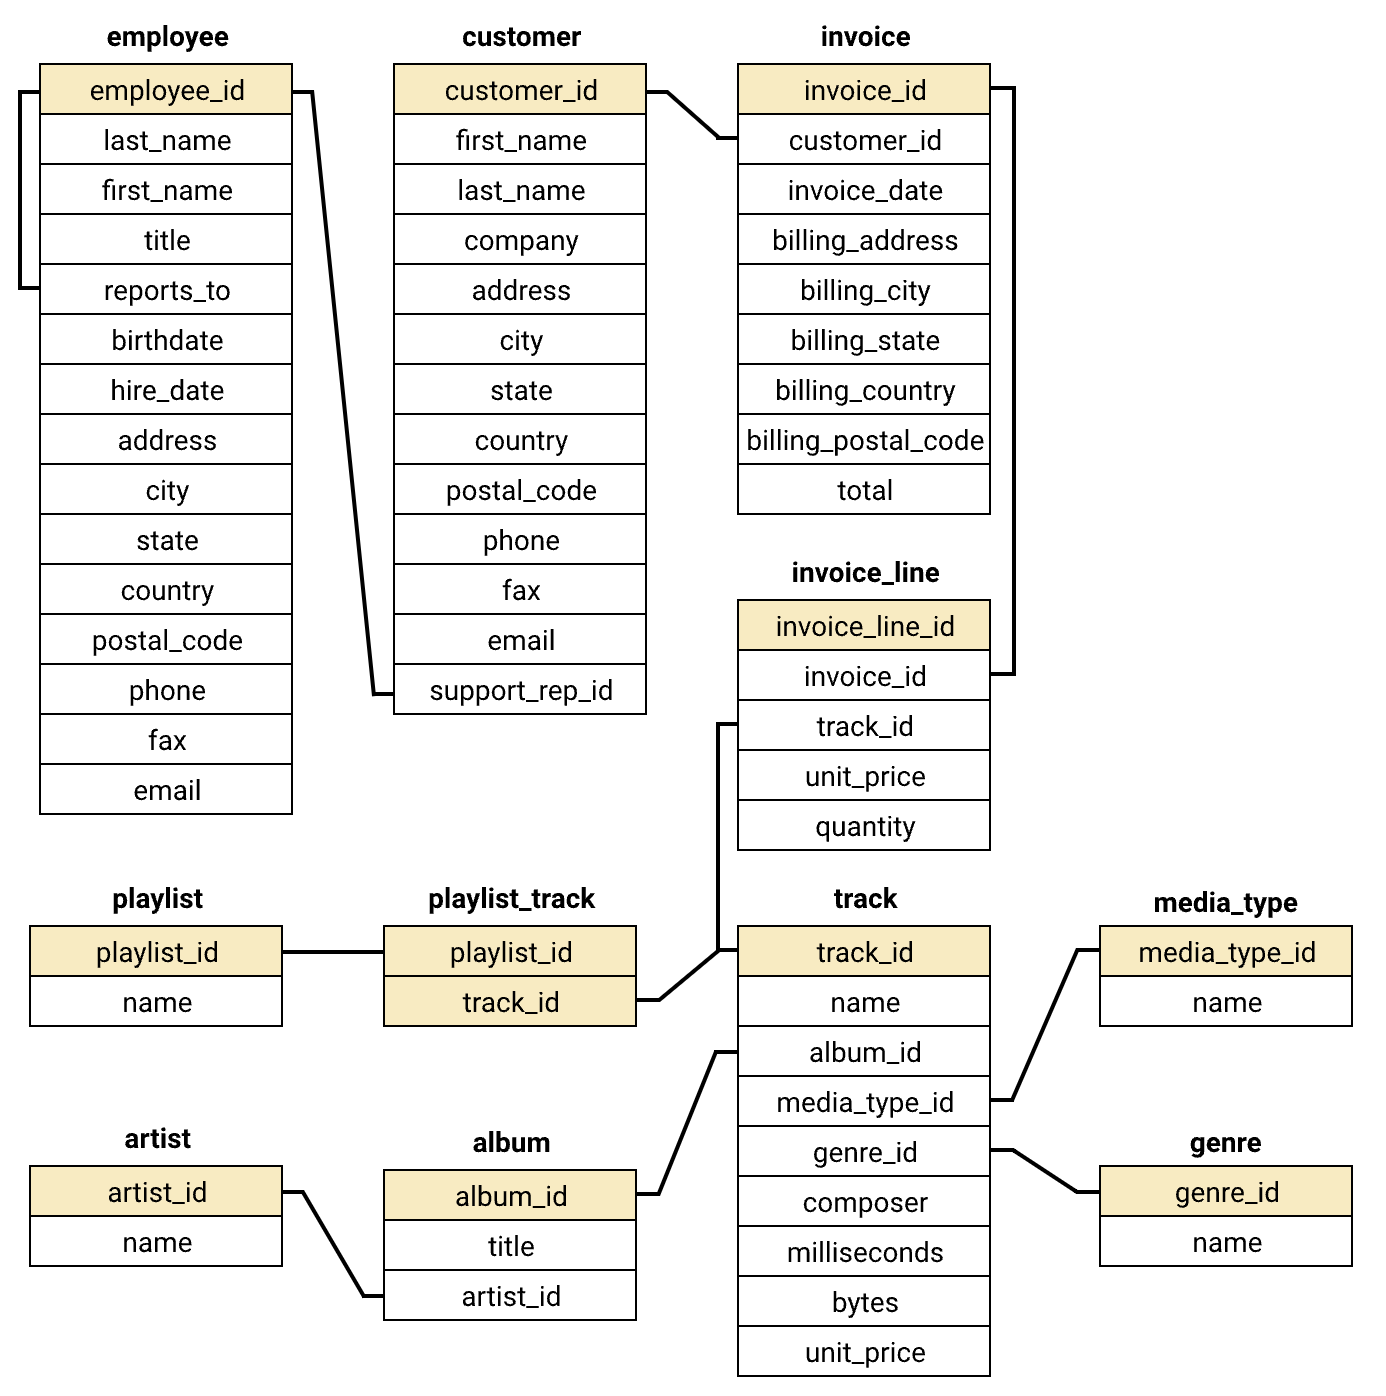

In [ ]:
vn.ask()

## Launch the User Interface
![vanna-flask](https://vanna.ai/blog/img/vanna-flask.gif)

In [ ]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn)
app.run()